In [1]:
import requests

urls = [
    "https://github.com/naveenkumar12624/Mini-Project_Age_and_Gender_Prediction/raw/main/opencv_face_detector.pbtxt",
    "https://github.com/naveenkumar12624/Mini-Project_Age_and_Gender_Prediction/raw/main/opencv_face_detector_uint8.pb",
    "https://github.com/naveenkumar12624/Mini-Project_Age_and_Gender_Prediction/raw/main/age_deploy.prototxt",
    "https://github.com/naveenkumar12624/Mini-Project_Age_and_Gender_Prediction/raw/main/age_net.caffemodel",
    "https://github.com/naveenkumar12624/Mini-Project_Age_and_Gender_Prediction/raw/main/gender_deploy.prototxt",
    "https://github.com/naveenkumar12624/Mini-Project_Age_and_Gender_Prediction/raw/main/gender_net.caffemodel"
]

for url in urls:
    response = requests.get(url)
    filename = url.split("/")[-1]
    with open(filename, 'wb') as f:
        f.write(response.content)
    print(f"Downloaded {filename}")


Downloaded opencv_face_detector.pbtxt
Downloaded opencv_face_detector_uint8.pb
Downloaded age_deploy.prototxt
Downloaded age_net.caffemodel
Downloaded gender_deploy.prototxt
Downloaded gender_net.caffemodel


Gender: Male
Age: 25-32 years


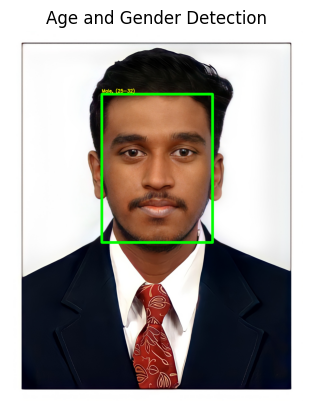

In [32]:
import cv2
import os
import sys
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def highlightFace(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    faceBoxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            faceBoxes.append([x1, y1, x2, y2])
            cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight / 150)), 8)
    return frameOpencvDnn, faceBoxes

def load_image_from_url(url):
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img = np.array(img)  # Convert PIL Image to NumPy array
        if img.shape[2] == 4:  # If PNG with alpha channel, convert to BGR
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        return img
    except Exception as e:
        print(f"Could not load image from URL: {e}")
        return None

if __name__ == "__main__":
    # Define paths and URL (use one of these)
    image_path = 'B:/OneDrive/Pictures/PERSONAL/212221240033.png'  # Local path example
    
    #else
    image_url = 'https://example.com/image.jpg'  # Web URL example

    # Define file paths for models
    faceProto = "opencv_face_detector.pbtxt"
    faceModel = "opencv_face_detector_uint8.pb"
    ageProto = "age_deploy.prototxt"
    ageModel = "age_net.caffemodel"
    genderProto = "gender_deploy.prototxt"
    genderModel = "gender_net.caffemodel"

    MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
    ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
    genderList = ['Male', 'Female']

    # Load the models for face, age, and gender detection
    faceNet = cv2.dnn.readNet(faceModel, faceProto)
    ageNet = cv2.dnn.readNet(ageModel, ageProto)
    genderNet = cv2.dnn.readNet(genderModel, genderProto)

    # Try to read the image from the local path
    frame = cv2.imread(image_path)
    if frame is None:  # If the local image path is incorrect or image cannot be read
        print(f"Could not read image at {image_path}, trying to load from URL...")
        frame = load_image_from_url(image_url)

    if frame is None:  # If both the local image and the URL failed
        print(f"Could not read image from URL, switching to live camera...")
        video = cv2.VideoCapture(0)  # Switch to live camera
        ret, frame = video.read()
        if not ret:
            print("Failed to capture from webcam")
            sys.exit(1)
        video.release()

    padding = 20

    # Detect faces
    resultImg, faceBoxes = highlightFace(faceNet, frame)
    if not faceBoxes:
        print("No face detected")

    for faceBox in faceBoxes:
        face = frame[max(0, faceBox[1] - padding): min(faceBox[3] + padding, frame.shape[0] - 1),
                     max(0, faceBox[0] - padding): min(faceBox[2] + padding, frame.shape[1] - 1)]

        blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)

        # Predict gender
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        print(f'Gender: {gender}')

        # Predict age
        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]
        print(f'Age: {age[1:-1]} years')

        # Display results on image
        cv2.putText(resultImg, f'{gender}, {age}', (faceBox[0], faceBox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)
    
    # Display the final image with detections using matplotlib
    captured_frame_rgb = cv2.cvtColor(resultImg, cv2.COLOR_BGR2RGB)
    plt.imshow(captured_frame_rgb)
    plt.title("Age and Gender Detection")
    plt.axis('off')  # Hide axis
    plt.show()
